In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
import os

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, recall_score, f1_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score

from scipy import stats as mstats
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.model_selection import KFold

!pip install mlflow

import kagglehub
path = kagglehub.dataset_download("dharun4772/doordash-eta-prediction")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.4/27.4 MB 32.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 36.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 623.0/623.0 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.2/203.2 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 2.5 MB/s eta 0:00:00


100%|██████████| 4.99M/4.99M [00:00<00:00, 50.0MB/s]

Extracting files...


In [2]:
print(os.listdir(os.getcwd()))
path = kagglehub.dataset_download('dharun4772/doordash-eta-prediction')

csv_file_path = os.path.join(path, 'historical_data.csv')

df = pd.read_csv(csv_file_path)

df.head()

['.config', 'sample_data']


,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0


We’re working with a DoorDash dataset to predict food delivery times. The goal is to build a model that accurately estimates how long it takes from when an order is placed to when it's delivered. The data includes features like order details (number of items, subtotal), restaurant info, and market conditions (available dashers, outstanding orders). We also have timestamps for when the order was placed and delivered, which helps us calculate the delivery time.

We’re choosing the following features because they directly impact the complexity and timing of the delivery process:
*   total_items: More items in an order can lead to longer preparation and packaging times, which can delay the delivery.
*   num_distinct_items: A higher number of distinct items may require more coordination in the kitchen, increasing the order complexity and affecting delivery time.
total_onshift_dashers: The number of available dashers influences how
*   total_onshift_dashers: The number of available dashers influences how quickly an order can be assigned and delivered. More available dashers typically result in faster deliveries.
*   total_busy_dashers: If many dashers are already working on other orders, it can create delays in assigning a dasher to a new order, impacting delivery time.

In [3]:
# Convert to datetime objects
df['actual_delivery_time'] = pd.to_datetime(df['actual_delivery_time'])
df['created_at'] = pd.to_datetime(df['created_at'])

# Calculate the difference in minutes
df['delivery_time_minutes'] = (df['actual_delivery_time'] - df['created_at']).dt.total_seconds() / 60
df.drop(['created_at', 'actual_delivery_time'], axis=1, inplace=True)

In [4]:
df.head(10)

,market_id,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,delivery_time_minutes
0,1.0,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0,62.983333
1,2.0,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0,67.066667
2,3.0,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0,29.683333
3,3.0,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0,51.250000
4,3.0,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0,39.833333
5,3.0,5477,NaN,1.0,3,5000,3,1500,1900,2.0,2.0,2.0,446,338.0,38.333333
6,3.0,5477,NaN,1.0,2,3900,2,1200,2700,10.0,9.0,9.0,446,638.0,26.400000
7,3.0,5477,NaN,1.0,4,4850,4,750,1800,7.0,8.0,7.0,446,626.0,32.750000
8,2.0,5477,indian,3.0,4,4771,3,820,1604,8.0,6.0,18.0,446,289.0,26.433333
9,3.0,5477,NaN,1.0,2,2100,2,700,1200,2.0,2.0,2.0,446,715.0,53.200000


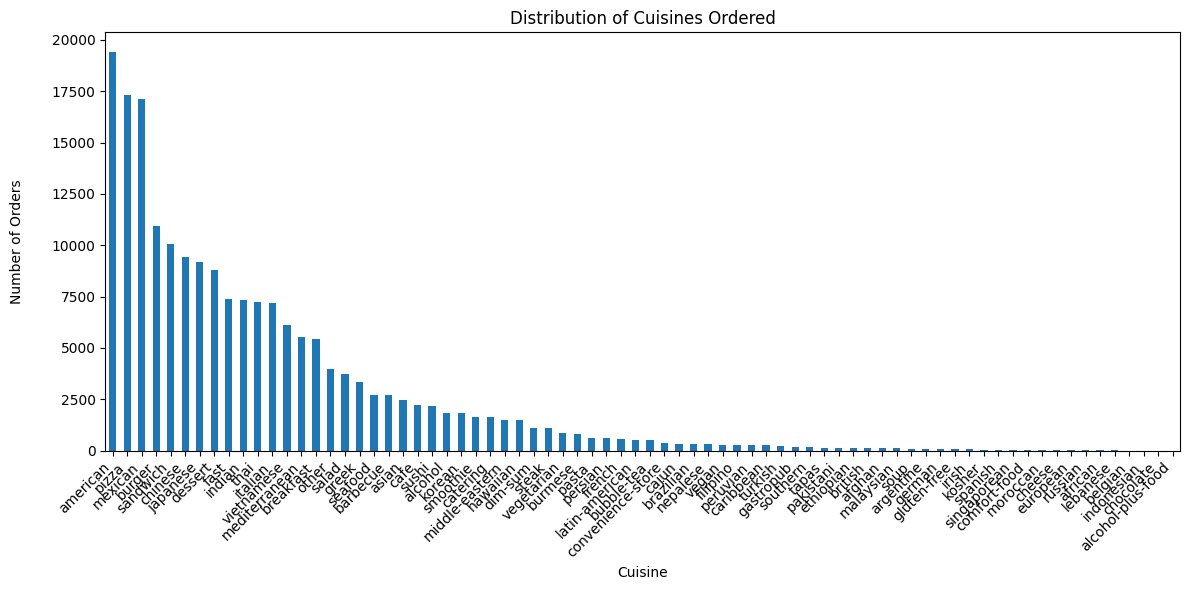

In [5]:
plt.figure(figsize=(12, 6))
df['store_primary_category'].value_counts().plot(kind='bar')
plt.title('Distribution of Cuisines Ordered')
plt.xlabel('Cuisine')
plt.ylabel('Number of Orders', labelpad=20)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [6]:
nan_count = df['store_primary_category'].isna().sum()
print(f"Number of NaNs in 'store_primary_category': {nan_count}")

df = df.dropna(subset=['store_primary_category'])

Number of NaNs in 'store_primary_category': 4760


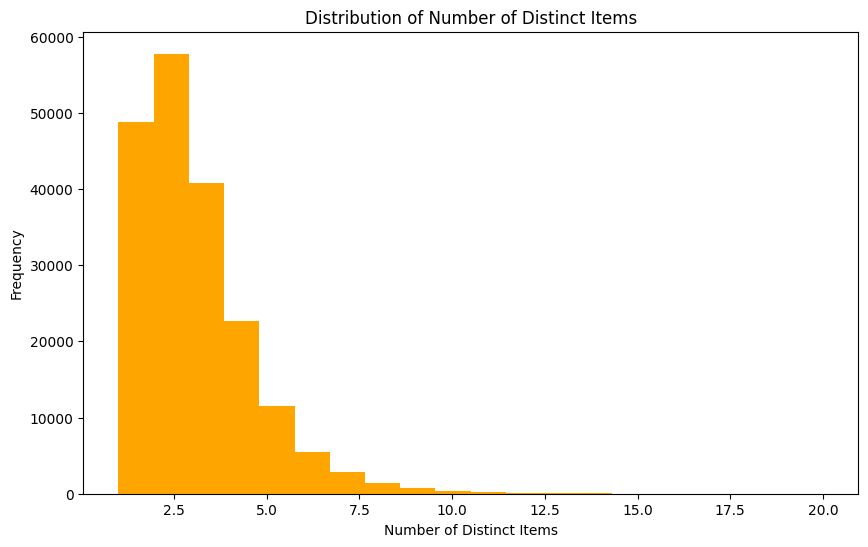

In [7]:
# Histograms for num_distinct_items and total_items
plt.figure(figsize=(10, 6))
plt.hist(df['num_distinct_items'], bins=20, color='orange')
plt.title('Distribution of Number of Distinct Items')
plt.xlabel('Number of Distinct Items')
plt.ylabel('Frequency')
plt.show()

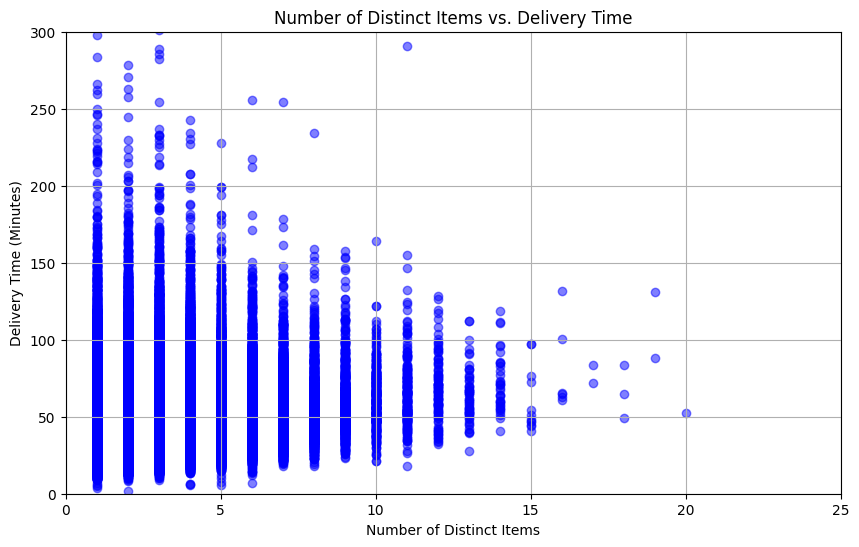

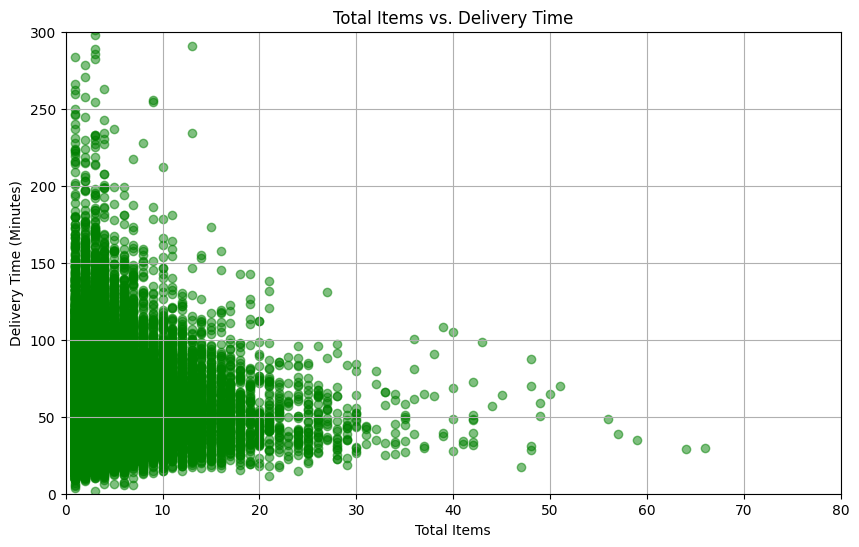

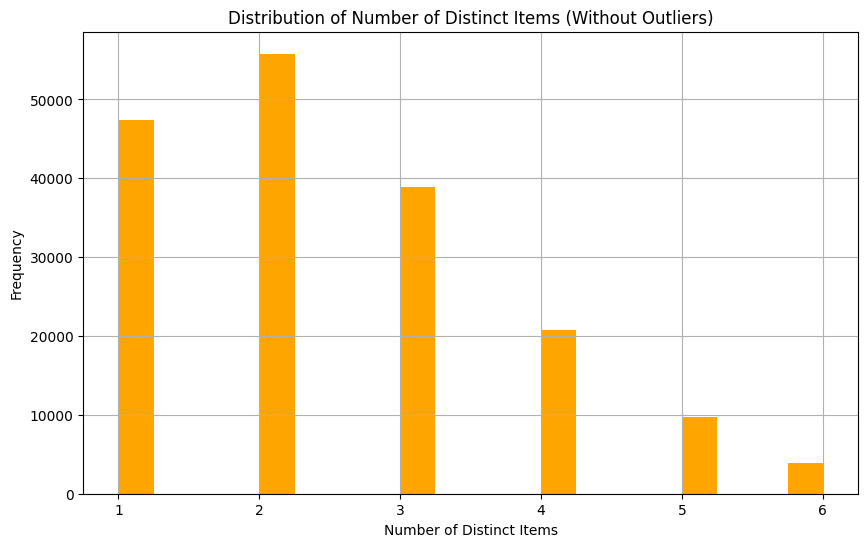

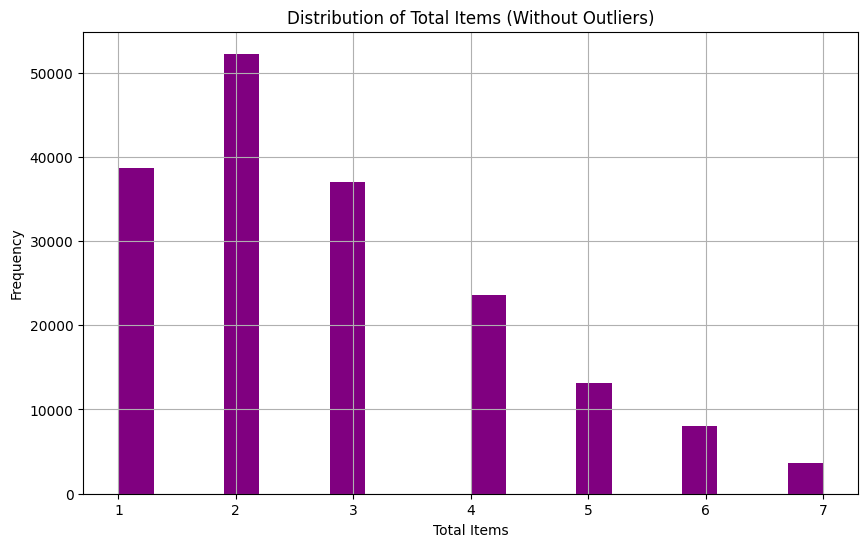

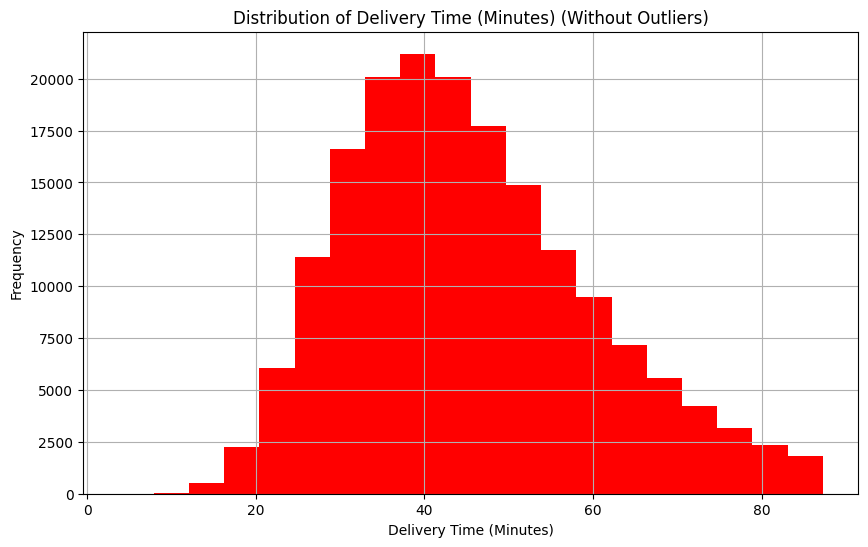

In [8]:
# Scatter plot: num_distinct_items vs. delivery_time_minutes
plt.figure(figsize=(10, 6))
plt.scatter(df['num_distinct_items'], df['delivery_time_minutes'], alpha=0.5, color='blue')
plt.title('Number of Distinct Items vs. Delivery Time')
plt.xlabel('Number of Distinct Items')
plt.ylabel('Delivery Time (Minutes)')
plt.grid(True)
plt.xlim(0,25)
plt.ylim(0,300)
plt.show()

# Scatter plot: total_items vs. delivery_time_minutes
plt.figure(figsize=(10, 6))
plt.scatter(df['total_items'], df['delivery_time_minutes'], alpha=0.5, color='green')
plt.title('Total Items vs. Delivery Time')
plt.xlabel('Total Items')
plt.ylabel('Delivery Time (Minutes)')
plt.xlim(0,80)
plt.ylim(0,300)
plt.grid(True)
plt.show()

# Remove outliers using the IQR method
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

df_filtered = df.copy()
df_filtered = remove_outliers(df_filtered, 'num_distinct_items')
df_filtered = remove_outliers(df_filtered, 'total_items')
df_filtered = remove_outliers(df_filtered, 'delivery_time_minutes')

# Histograms for num_distinct_items and total_items without outliers
plt.figure(figsize=(10, 6))
plt.hist(df_filtered['num_distinct_items'], bins=20, color='orange')
plt.title('Distribution of Number of Distinct Items (Without Outliers)')
plt.xlabel('Number of Distinct Items')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(df_filtered['total_items'], bins=20, color='purple')
plt.title('Distribution of Total Items (Without Outliers)')
plt.xlabel('Total Items')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Histogram for delivery_time_minutes without outliers
plt.figure(figsize=(10, 6))
plt.hist(df_filtered['delivery_time_minutes'], bins=20, color='red')
plt.title('Distribution of Delivery Time (Minutes) (Without Outliers)')
plt.xlabel('Delivery Time (Minutes)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [9]:
missing_values = df.isnull().sum()
print("Missing Values:\n", missing_values)

missing_proportion = df.isnull().mean() * 100
print("\nMissing Value Proportion (%):\n", missing_proportion)

for column in df.select_dtypes(include=np.number).columns:
  print(f"Range for '{column}': [{df[column].min()}, {df[column].max()}]")

Missing Values:
 market_id                                         495
store_id                                            0
store_primary_category                              0
order_protocol                                    488
total_items                                         0
subtotal                                            0
num_distinct_items                                  0
min_item_price                                      0
max_item_price                                      0
total_onshift_dashers                           15717
total_busy_dashers                              15717
total_outstanding_orders                        15717
estimated_order_place_duration                      0
estimated_store_to_consumer_driving_duration      515
delivery_time_minutes                               7
dtype: int64

Missing Value Proportion (%):
 market_id                                       0.256919
store_id                                        0.000000
store_primary_

In [10]:
X = df_filtered[['total_items', 'num_distinct_items', 'total_onshift_dashers', 'total_busy_dashers']]
y = df_filtered['delivery_time_minutes']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")

Training set size: 141072
Validation set size: 35269


In [11]:
columns_to_drop = ['estimated_store_to_consumer_driving_duration', 'estimated_order_place_duration', 'min_item_price', 'max_item_price', 'market_id', 'store_id', 'store_primary_category', 'order_protocol']
df_filtered = df_filtered.drop(columns=columns_to_drop)

df_filtered = df_filtered.reset_index(drop = True)
df_filtered

,total_items,subtotal,num_distinct_items,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,delivery_time_minutes
0,4,3441,4,33.0,14.0,21.0,62.983333
1,1,1900,1,1.0,2.0,2.0,67.066667
2,4,4771,3,8.0,6.0,18.0,26.433333
3,1,1525,1,5.0,6.0,8.0,37.883333
4,2,3620,2,5.0,5.0,7.0,49.800000
...,...,...,...,...,...,...,...
176336,3,1389,3,17.0,17.0,23.0,65.116667
176337,6,3010,4,12.0,11.0,14.0,56.383333
176338,5,1836,3,39.0,41.0,40.0,50.133333
176339,1,1175,1,7.0,7.0,12.0,65.116667


In [12]:
df_filtered['Busyness Percentage'] = (df_filtered['total_busy_dashers'] / df_filtered['total_onshift_dashers'])

new_df = df_filtered.drop(['total_busy_dashers', 'total_onshift_dashers'], axis=1)

new_df = new_df[['total_items', 'num_distinct_items', 'Busyness Percentage', 'subtotal', 'total_outstanding_orders', 'delivery_time_minutes']]

In [13]:
final_df = new_df[~new_df['Busyness Percentage'].isin([np.inf, -np.inf])]

In [14]:
final_df['delivery_time_binary'] = (final_df['delivery_time_minutes'] >= 30).astype(int)

cleaned_df = final_df.dropna()
cleaned_df

<ipython-input-14-3951c4e0f76d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['delivery_time_binary'] = (final_df['delivery_time_minutes'] >= 30).astype(int)


,total_items,num_distinct_items,Busyness Percentage,subtotal,total_outstanding_orders,delivery_time_minutes,delivery_time_binary
0,4,4,0.424242,3441,21.0,62.983333,1
1,1,1,2.000000,1900,2.0,67.066667,1
2,4,3,0.750000,4771,18.0,26.433333,0
3,1,1,1.200000,1525,8.0,37.883333,1
4,2,2,1.000000,3620,7.0,49.800000,1
...,...,...,...,...,...,...,...
176336,3,3,1.000000,1389,23.0,65.116667,1
176337,6,4,0.916667,3010,14.0,56.383333,1
176338,5,3,1.051282,1836,40.0,50.133333,1
176339,1,1,1.000000,1175,12.0,65.116667,1


In [15]:
X = cleaned_df[['total_items', 'num_distinct_items', 'Busyness Percentage',  'subtotal', 'total_outstanding_orders']]
y = cleaned_df['delivery_time_minutes']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=21)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.4, random_state=21)

scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train = scaler_X.fit_transform(X_train)
X_val = scaler_X.transform(X_val)
X_test = scaler_X.transform(X_test)

y_train = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_val = scaler_y.transform(y_val.values.reshape(-1, 1))
y_test = scaler_y.transform(y_test.values.reshape(-1, 1))

Training set size: 127160
Validation set size: 31790


**Metric**

We used Mean Squared Error and Mean Absolute Error for observing how the model is doing, but in terms of actually fitting the model and analysing learning rates, we only used MSE to heavily penalize large errors in delivery times as the scale of delivery times isn't that high in the first place ranging from 10 minutes to 60 minutes.

**Training Process**

First we normalize the data, then fit the model on that for 3 epochs (discretionary decision) and then after re-scale to calculate performance metrics and analyse the training process based on the MSE loss function.

As for our learning rate, we referenced the method talked about in class where you choose 1/2 * maximal_LR which is the maximum LR for when validation loss starts to diverge, which we saw in the previous code segment. After selecting this LR, the NN was trained over 12 epochs, and as shown in the graph above we saw the val loss decrease sharply during the first 3 epochs then start to plateau.

Given that delivery times are prone to noise from real world circumstances we also wanted to train a classification neural network in order to create more broad categories from which we can predict the delivery time. The three category's we decided upon was Short (<15 minutes), Medium (15-30 minutes), and Long (>30 minutes).

Testing learning rate: 0.0001


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/3
1739/1739 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - accuracy: 0.7650 - loss: 0.6656 - val_accuracy: 0.8576 - val_loss: 0.4032
Epoch 2/3
1739/1739 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8591 - loss: 0.4187 - val_accuracy: 0.8576 - val_loss: 0.3886
Epoch 3/3
1739/1739 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8564 - loss: 0.4053 - val_accuracy: 0.8576 - val_loss: 0.3852
Testing learning rate: 0.0005
Epoch 1/3
1739/1739 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8001 - loss: 0.5535 - val_accuracy: 0.8576 - val_loss: 0.3838
Epoch 2/3
1739/1739 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8580 - loss: 0.3955 - val_accuracy: 0.8576 - val_loss: 0.3816
Epoch 3/3
1739/1739 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8609 - loss: 0.3845 - val_accuracy: 0.8576 - val_loss: 0.3805
Testing learning rate: 0.001
Epoch 1/3
1739/1739 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.8515 - loss: 0.4526 - val_accuracy: 0.8576 - val_loss: 0.3826
Epoch 2/3
1739/1739 ━━━━━━━━━━━━━━━━━

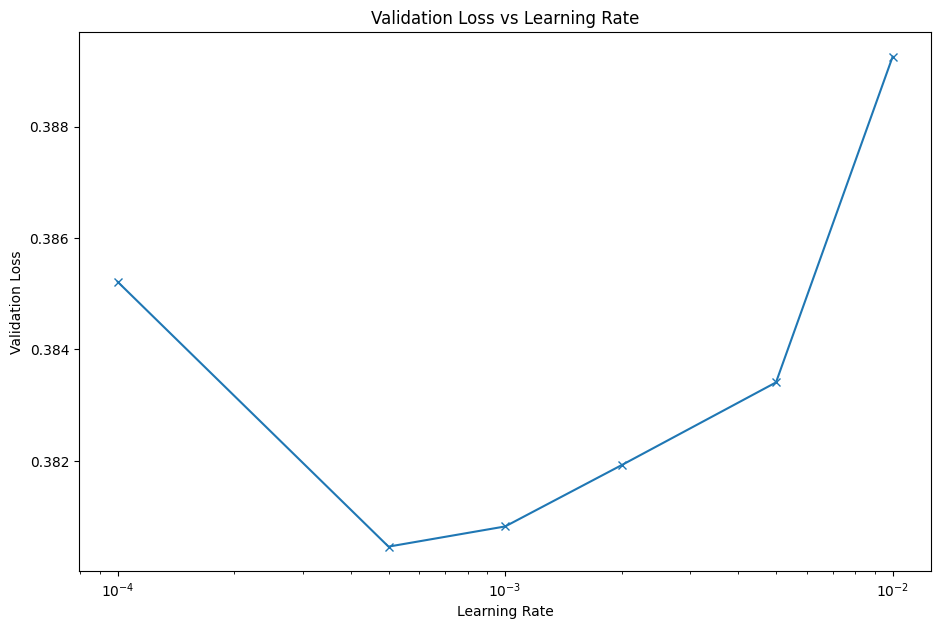

In [16]:
X = cleaned_df[['total_items', 'num_distinct_items', 'Busyness Percentage', 'subtotal', 'total_outstanding_orders']]
y = cleaned_df['delivery_time_minutes']

y_categories = pd.cut(y, bins=[0, 15, 30, np.inf], labels=['Short', 'Medium', 'Long'])

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_categories)

X_train, X_temp, y_train, y_temp = train_test_split(X, y_encoded, test_size=0.3, random_state=21)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.4, random_state=21)

scaler_X = StandardScaler()
X_train = scaler_X.fit_transform(X_train)
X_val = scaler_X.transform(X_val)

learning_rates = [0.0001, 0.0005, 0.001, 0.002, 0.005, 0.01]

val_losses = []

def create_model():
    model = Sequential([
        Dense(64, activation='relu', input_dim=X_train.shape[1]),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(3, activation='softmax')
    ])
    return model

for lr in learning_rates:
    print(f"Testing learning rate: {lr}")
    model = create_model()
    model.compile(optimizer=Adam(learning_rate=lr), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=3,
        batch_size=64,
        verbose=1
    )

    final_loss = history.history['val_loss'][-1]
    val_losses.append(final_loss)

plt.figure(figsize=(11, 7))
plt.plot(learning_rates, val_losses, marker='x')
plt.xscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('Validation Loss')
plt.title('Validation Loss vs Learning Rate')
plt.show()

The above graph depicts code we used to find what the best learning rate would be. We used a variety of learning rates eventually narrowing it down to the following range in which the global minima is as well as where the learning rate begins to rise again.

Now we applied the learning rate to the data set and added a couple of different features to enhance the models ability to detect trends and relationships. We also handled outliers earlier. We defined callbacks that would reduce learning rate if the model hit a plateau and added early stopping as well as dropout to avoid overfitting.

Epoch 1/12


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3478/3478 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - accuracy: 0.8040 - loss: 1.0712 - val_accuracy: 0.8595 - val_loss: 0.3959 - learning_rate: 0.0010
Epoch 2/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.8602 - loss: 0.4010 - val_accuracy: 0.8598 - val_loss: 0.3874 - learning_rate: 0.0010
Epoch 3/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.8605 - loss: 0.3966 - val_accuracy: 0.8598 - val_loss: 0.3863 - learning_rate: 0.0010
Epoch 4/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - accuracy: 0.8600 - loss: 0.3948 - val_accuracy: 0.8595 - val_loss: 0.3860 - learning_rate: 0.0010
Epoch 5/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - accuracy: 0.8597 - loss: 0.3948 - val_accuracy: 0.8596 - val_loss: 0.3859 - learning_rate: 0.0010
Epoch 6/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.8605 - loss: 0.3922 - val_accuracy: 0.8597 - val_loss: 0.3888 - learning_rate: 0.0010
Epoch 7/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.8599 - loss:

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Test Set Metrics:
Precision: 0.7372
Recall: 0.8584
F1 Score: 0.7932
MAE: 2.15 minutes
MSE: 32.98 minutes²


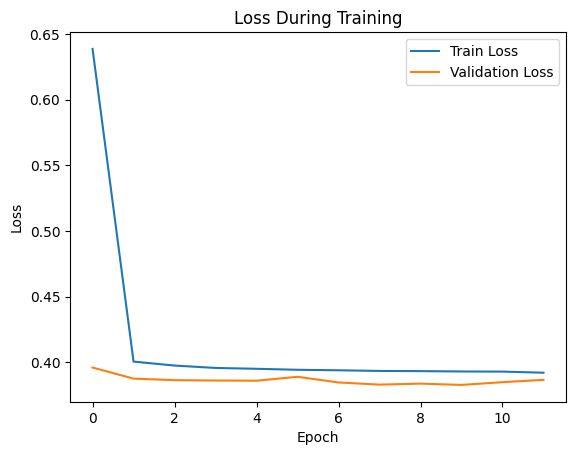

In [17]:
X = cleaned_df[['total_items', 'num_distinct_items', 'Busyness Percentage', 'subtotal', 'total_outstanding_orders']].copy()
y = cleaned_df['delivery_time_minutes']

X['subtotal_per_item'] = X['subtotal'] / (X['total_items'] + 1)
X['busyness_item_ratio'] = X['Busyness Percentage'] / (X['total_items'] + 1)

# X['subtotal'] = mstats.winsorize(X['subtotal'], limits=[0.01, 0.01])

y_categories = pd.cut(y, bins=[0, 15, 30, np.inf], labels=['Short', 'Medium', 'Long'])

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_categories)

scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y_encoded, test_size=0.3, random_state=21)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=21)

def create_model():
    model = Sequential([
        Dense(128, activation='relu', kernel_regularizer=l2(0.01), input_dim=X.shape[1]),
        BatchNormalization(),
        Dropout(0.3),
        Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.3),
        Dense(3, activation='softmax')  # 3 output classes: Short, Medium, Long
    ])
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model


model = create_model()

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=12,
                    batch_size=32,
                    callbacks=[reduce_lr, early_stopping],
                    verbose=1)

y_pred_prob = model.predict(X_test)
y_pred_classes = np.argmax(y_pred_prob, axis=1)

precision = precision_score(y_test, y_pred_classes, average='weighted')
recall = recall_score(y_test, y_pred_classes, average='weighted')
f1 = f1_score(y_test, y_pred_classes, average='weighted')

y_test_actual = [15 if label == 0 else 30 if label == 1 else 45 for label in y_test]
y_pred_actual = [15 if label == 0 else 30 if label == 1 else 45 for label in y_pred_classes]

mae = mean_absolute_error(y_test_actual, y_pred_actual)
mse = mean_squared_error(y_test_actual, y_pred_actual)

print(f"\nTest Set Metrics:")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"MAE: {mae:.2f} minutes")
print(f"MSE: {mse:.2f} minutes²")

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss During Training')
plt.show()

Finally we implement cross validation here with kfold using 5 different folds to validate our models accurace over multiple test and validation splits as opposed to just basing our assumption of the models accuracy off of a singular test.

In [18]:
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=21)

precision_scores = []
recall_scores = []
f1_scores = []
mae_scores = []
mse_scores = []

for fold, (train_index, val_index) in enumerate(kf.split(X_scaled)):
    print(f"\nTraining Fold {fold + 1}/{k}")

    X_train, X_val = X_scaled[train_index], X_scaled[val_index]
    y_train, y_val = y_encoded[train_index], y_encoded[val_index]

    model = create_model()

    history = model.fit(X_train, y_train,
                        validation_data=(X_val, y_val),
                        epochs=20,
                        batch_size=64,
                        callbacks=[reduce_lr, early_stopping],
                        verbose=1)

    y_pred_prob = model.predict(X_val)
    y_pred_classes = np.argmax(y_pred_prob, axis=1)

    precision = precision_score(y_val, y_pred_classes, average='weighted')
    recall = recall_score(y_val, y_pred_classes, average='weighted')
    f1 = f1_score(y_val, y_pred_classes, average='weighted')

    y_val_actual = [15 if label == 0 else 30 if label == 1 else 45 for label in y_val]
    y_pred_actual = [15 if label == 0 else 30 if label == 1 else 45 for label in y_pred_classes]

    mae = mean_absolute_error(y_val_actual, y_pred_actual)
    mse = mean_squared_error(y_val_actual, y_pred_actual)

    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    mae_scores.append(mae)
    mse_scores.append(mse)

    print(f"Fold {fold + 1} - Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}, MAE: {mae:.2f}, MSE: {mse:.2f}")

print("\nCross-Validation Results:")
print(f"Average Precision: {np.mean(precision_scores):.4f}")
print(f"Average Recall: {np.mean(recall_scores):.4f}")
print(f"Average F1 Score: {np.mean(f1_scores):.4f}")
print(f"Average MAE: {np.mean(mae_scores):.2f} minutes")
print(f"Average MSE: {np.mean(mse_scores):.2f} minutes²")


Training Fold 1/5
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1987/1987 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.8127 - loss: 1.1165 - val_accuracy: 0.8580 - val_loss: 0.3946 - learning_rate: 0.0010
Epoch 2/20
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.8603 - loss: 0.3995 - val_accuracy: 0.8580 - val_loss: 0.3882 - learning_rate: 0.0010
Epoch 3/20
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.8614 - loss: 0.3928 - val_accuracy: 0.8580 - val_loss: 0.3893 - learning_rate: 0.0010
Epoch 4/20
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.8594 - loss: 0.3934 - val_accuracy: 0.8580 - val_loss: 0.3864 - learning_rate: 0.0010
Epoch 5/20
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.8592 - loss: 0.3932 - val_accuracy: 0.8580 - val_loss: 0.3912 - learning_rate: 0.0010
994/994 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Fold 1 - Precision: 0.7363, Recall: 0.8580, F1 Score: 0.7925, MAE: 2.15, MSE: 32.99

Training Fold 2/5
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1987/1987 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.7921 - loss: 1.1710 - val_accuracy: 0.8608 - val_loss: 0.3955 - learning_rate: 0.0010
Epoch 2/20
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8601 - loss: 0.3985 - val_accuracy: 0.8608 - val_loss: 0.3891 - learning_rate: 0.0010
Epoch 3/20
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.8612 - loss: 0.3925 - val_accuracy: 0.8608 - val_loss: 0.3896 - learning_rate: 0.0010
Epoch 4/20
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.8589 - loss: 0.3945 - val_accuracy: 0.8608 - val_loss: 0.3856 - learning_rate: 0.0010
Epoch 5/20
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.8596 - loss: 0.3919 - val_accuracy: 0.8606 - val_loss: 0.3869 - learning_rate: 0.0010
994/994 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Fold 2 - Precision: 0.7410, Recall: 0.8608, F1 Score: 0.7965, MAE: 2.11, MSE: 32.33

Training Fold 3/5
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1987/1987 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.8157 - loss: 1.1134 - val_accuracy: 0.8623 - val_loss: 0.3923 - learning_rate: 0.0010
Epoch 2/20
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.8591 - loss: 0.3987 - val_accuracy: 0.8623 - val_loss: 0.3919 - learning_rate: 0.0010
Epoch 3/20
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.8591 - loss: 0.3962 - val_accuracy: 0.8623 - val_loss: 0.3850 - learning_rate: 0.0010
Epoch 4/20
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.8579 - loss: 0.3960 - val_accuracy: 0.8623 - val_loss: 0.3851 - learning_rate: 0.0010
Epoch 5/20
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8584 - loss: 0.3943 - val_accuracy: 0.8623 - val_loss: 0.3840 - learning_rate: 0.0010
994/994 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Fold 3 - Precision: 0.7776, Recall: 0.8623, F1 Score: 0.7986, MAE: 2.09, MSE: 32.30

Training Fold 4/5
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1987/1987 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.8274 - loss: 1.0607 - val_accuracy: 0.8577 - val_loss: 0.3970 - learning_rate: 0.0010
Epoch 2/20
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.8605 - loss: 0.3971 - val_accuracy: 0.8577 - val_loss: 0.3958 - learning_rate: 0.0010
Epoch 3/20
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.8600 - loss: 0.3955 - val_accuracy: 0.8577 - val_loss: 0.3908 - learning_rate: 0.0010
Epoch 4/20
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.8610 - loss: 0.3892 - val_accuracy: 0.8577 - val_loss: 0.3923 - learning_rate: 0.0010
Epoch 5/20
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8580 - loss: 0.3947 - val_accuracy: 0.8577 - val_loss: 0.3900 - learning_rate: 0.0010
994/994 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
Fold 4 - Precision: 0.7357, Recall: 0.8577, F1 Score: 0.7920, MAE: 2.16, MSE: 33.27

Training Fold 5/5
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1987/1987 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.8163 - loss: 1.0883 - val_accuracy: 0.8583 - val_loss: 0.3963 - learning_rate: 0.0010
Epoch 2/20
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.8591 - loss: 0.3993 - val_accuracy: 0.8583 - val_loss: 0.3926 - learning_rate: 0.0010
Epoch 3/20
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.8597 - loss: 0.3942 - val_accuracy: 0.8583 - val_loss: 0.3925 - learning_rate: 0.0010
Epoch 4/20
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.8587 - loss: 0.3946 - val_accuracy: 0.8583 - val_loss: 0.3911 - learning_rate: 0.0010
Epoch 5/20
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8596 - loss: 0.3904 - val_accuracy: 0.8583 - val_loss: 0.3927 - learning_rate: 0.0010
994/994 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Fold 5 - Precision: 0.7369, Recall: 0.8583, F1 Score: 0.7930, MAE: 2.15, MSE: 33.20

Cross-Validation Results:
Average Precision: 0.7455
Average Recall: 0.8594
Average F1 Score: 0.7945
Average MAE: 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
